[Sentiment140 dataset](http://help.sentiment140.com/home)

In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

In [3]:
SENTIMENT_CSV = "./data/training_cleaned.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



In [4]:
def parse_data_from_file(filename):
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            labels.append(int(row[0] == '4'))
            sentences.append(row[5])
        
    return sentences, labels

In [5]:
# Test your function
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


In [6]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels) # * unzips the two lists

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



## Training - Validation Split

Now you will code the `train_val_split`, which given the list of sentences, the list of labels and the proportion of data for the training set, should return the training and validation sentences and labels:

In [7]:
def train_val_split(sentences, labels, training_split):
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [8]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


In [9]:
def fit_tokenizer(train_sentences, oov_token):
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [10]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128293 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [11]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    return pad_trunc_sequences

In [12]:
# Test your function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


In [13]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Using pre-defined Embeddings

100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [14]:
# Define path to file containing the embeddings
GLOVE_FILE = './data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [15]:
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [16]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [24]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [18]:
# GRADED FUNCTION: create_model
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    
    model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
        #tf.keras.layers.Conv1D(128, 5, activation='relu'),
        #tf.keras.layers.GlobalMaxPooling1D(),
        #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
        tf.keras.layers.Dropout(.2),
        #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
        #tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [19]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
4500/4500 [==============================] - 20s 4ms/step - loss: 0.5601 - accuracy: 0.7088 - val_loss: 0.5324 - val_accuracy: 0.7316
Epoch 2/20
4500/4500 [==============================] - 18s 4ms/step - loss: 0.5130 - accuracy: 0.7470 - val_loss: 0.4981 - val_accuracy: 0.7575
Epoch 3/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4983 - accuracy: 0.7568 - val_loss: 0.4892 - val_accuracy: 0.7631
Epoch 4/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4881 - accuracy: 0.7646 - val_loss: 0.4852 - val_accuracy: 0.7617
Epoch 5/20
4500/4500 [==============================] - 19s 4ms/step - loss: 0.4808 - accuracy: 0.7696 - val_loss: 0.4783 - val_accuracy: 0.7674
Epoch 6/20
4500/4500 [==============================] - 22s 5ms/step - loss: 0.4740 - accuracy: 0.7734 - val_loss: 0.4801 - val_accuracy: 0.7662
Epoch 7/20
4500/4500 [==============================] - 24s 5ms/step - loss: 0.4704 - accuracy: 0.7757 - val_loss: 0.4763 - val_ac

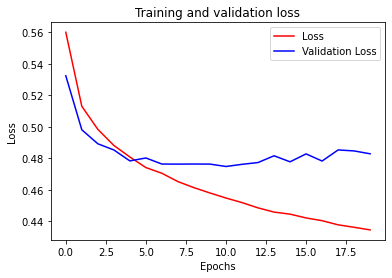

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

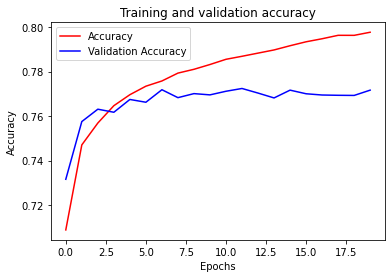

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [22]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00094


In [23]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)